# Visualizations
## Import Packages & Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

df = pd.read_csv('../data/us_accidents_expanded.csv')

## Accident Time Frequency
### Hour of Day

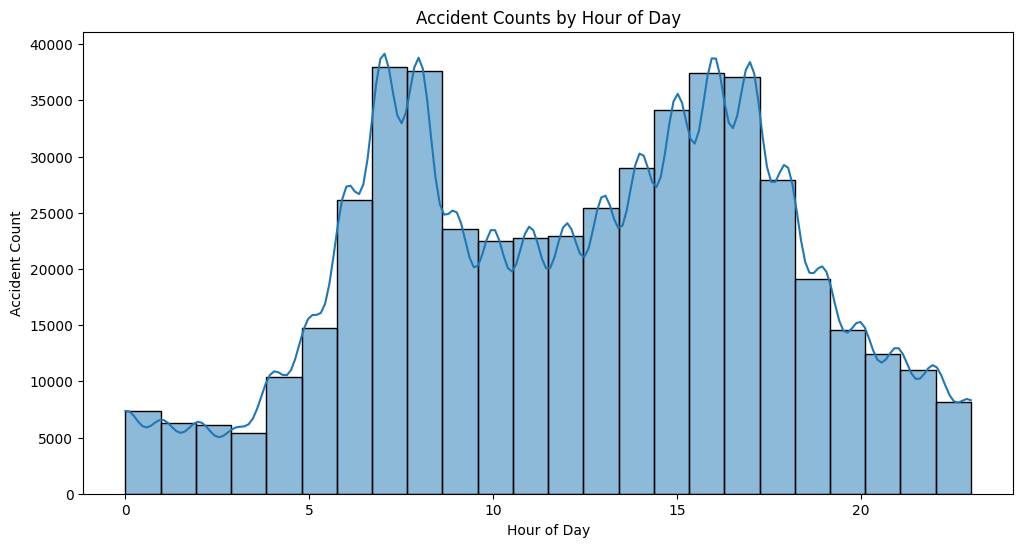

In [2]:
df_freq = df.copy()
df_freq['Hour'] = pd.to_datetime(df_freq['Start_Datetime']).dt.hour
plt.figure(figsize=(12, 6))
sns.histplot(df_freq['Hour'], bins=24, kde=True)
plt.title("Accident Counts by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Accident Count")
plt.show()

### Day of Week

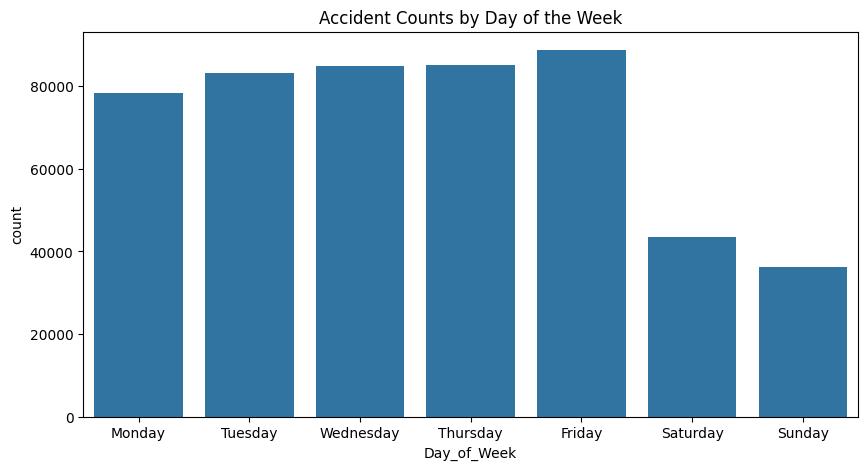

In [3]:
df_freq['Day_of_Week'] = pd.to_datetime(df_freq['Start_Date']).dt.day_name()
plt.figure(figsize=(10, 5))
sns.countplot(data=df_freq, x='Day_of_Week', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Accident Counts by Day of the Week")
plt.show()

## Principal Component Analysis (PCA)
We can use principal component analysis (PCA) to try and plot the data on a 3D
scatter plot to see if we have any clusters. First, we need to process the dataset
so PCA can run on it.

In [4]:
df_pca = df.copy()

# change severity to string
df_pca['Severity'] = df_pca['Severity'].astype(str)

# drop timestamps
df_pca = df_pca.drop(columns=['Start_Datetime', 'End_Datetime', 'Weather_Timestamp', 'Start_Date', 'End_Date', 'Start_Time', 'End_Time'])
# todo, encode time numerically

# drop address information and description
df_pca = df_pca.drop(columns=['Description', 'Street', 'City', 'County', 'Zipcode'])

# one-hot encode airport code and wind direction
df_pca = pd.get_dummies(df_pca, columns=['Airport_Code'])

# change day/night to true/false respectively
day_night = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
df_pca[day_night] = df_pca[day_night].replace('Day', True)
df_pca[day_night] = df_pca[day_night].replace('Night', False)


# normalize numerical features
scaler = StandardScaler()
numeric_columns = df_pca.select_dtypes(include=['number']).columns
df_pca[numeric_columns] = scaler.fit_transform(df_pca[numeric_columns])

# PCA doesn't allow for any missing values
df_pca = df_pca.dropna()

df_pca.head()


,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),...,Airport_Code_KY23,Airport_Code_KY50,Airport_Code_KY51,Airport_Code_KY63,Airport_Code_KY70,Airport_Code_KYIP,Airport_Code_KYKM,Airport_Code_KYNG,Airport_Code_KZPH,Airport_Code_KZZV
0,2,-1.097370,0.205857,-1.092076,0.205711,-0.317949,0.808087,0.784009,-0.124196,0.380086,...,False,False,False,False,False,False,False,False,False,False
1,2,0.548988,0.996080,0.557462,0.997098,-0.286397,-0.876113,-0.824252,-0.737528,0.370172,...,False,False,False,False,False,False,False,False,False,False
2,2,-0.304695,-1.479755,-0.297820,-1.482269,-0.305553,0.334406,0.358293,0.357707,0.251202,...,False,False,False,False,False,False,False,False,False,False
3,2,1.473787,0.100155,1.484206,0.101072,0.275898,-1.823476,-2.148703,0.927230,-1.037630,...,False,False,False,False,False,False,False,False,False,False
4,2,-0.159904,-1.393137,-0.152741,-1.395597,-0.292031,-1.034007,-0.871554,-1.350860,0.231374,...,False,False,False,False,False,False,False,False,False,False


Now was can reduce the feature dimensionality to 3.

In [5]:
pca = PCA(n_components=3)
X = pca.fit_transform(df_pca.drop(columns=['Severity']))
pca.explained_variance_ratio_

array([0.1851563 , 0.15003945, 0.08648348])

Next up, we can plot these reduced data to a 3D scatter plot.

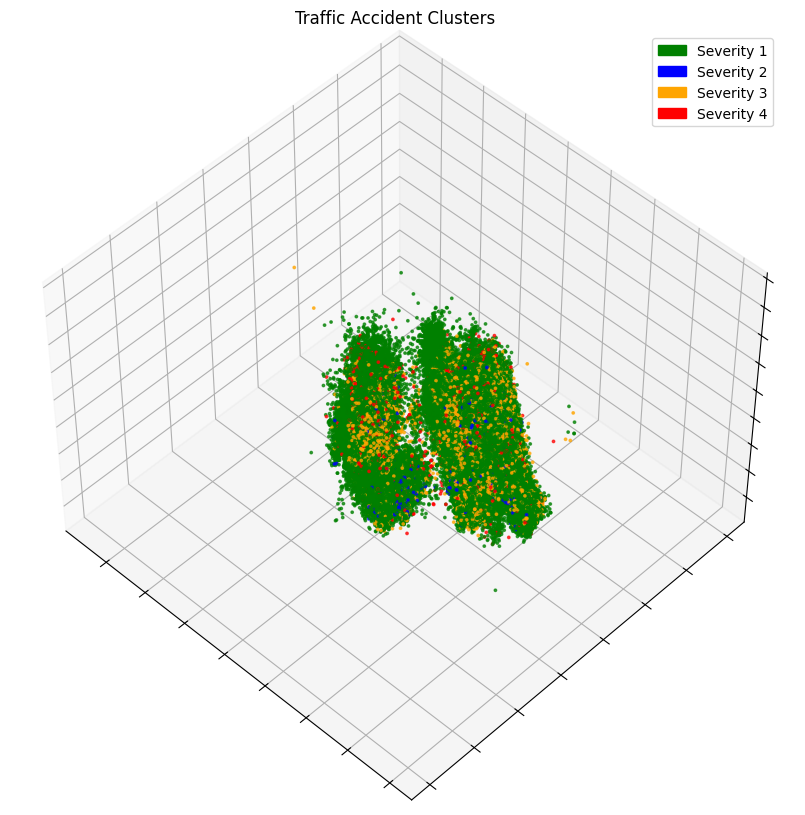

In [6]:
# custom color map
severity_map = {1: 'green', 2: 'blue', 3: 'orange', 4: 'red'}
custom_cmap = mcolors.ListedColormap(['blue', 'green', 'orange', 'red'])

# 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d', elev=48, azim=134)

sc = ax.scatter(
    X[:, 0],
    X[:, 1],
    X[:, 2],
    c=df_pca['Severity'].astype(int),
    s=3,
    cmap=custom_cmap,
    alpha=0.7
)

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

# legend & title
handles = [
    mpatches.Patch(color='green', label='Severity 1'),
    mpatches.Patch(color='blue', label='Severity 2'),
    mpatches.Patch(color='orange', label='Severity 3'),
    mpatches.Patch(color='red', label='Severity 4')
]
plt.legend(handles=handles, loc='best')
plt.title('Traffic Accident Clusters');

### State Accident Counts

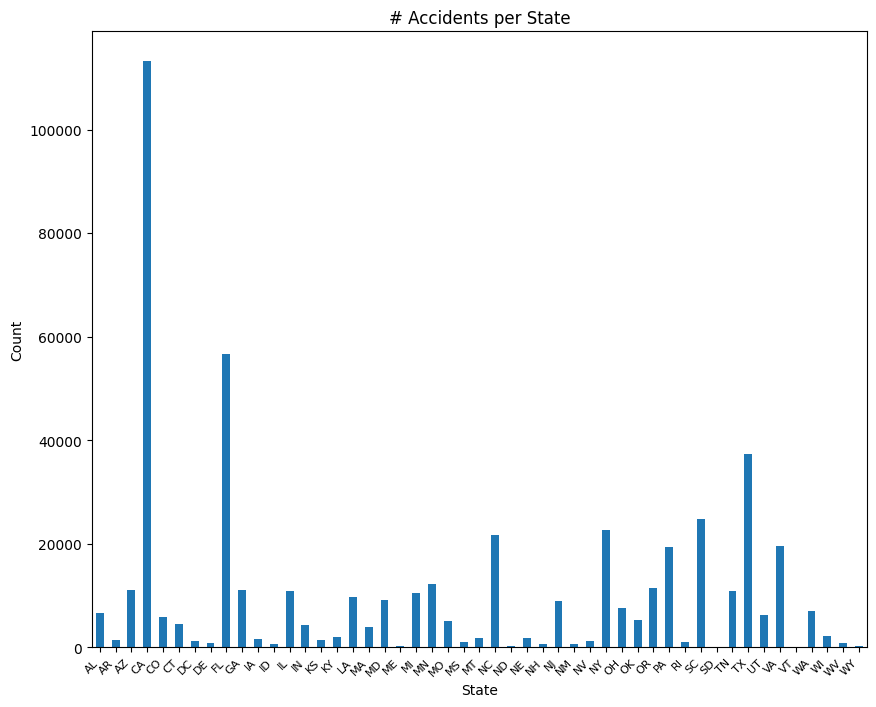

In [7]:
state_columns = [col for col in df.columns if col.startswith('State_')]
state_counts = df[state_columns].sum(axis=0)
state_counts.index = state_counts.index.str.replace('State_', '')

state_counts.plot(kind='bar', figsize=(10,8))
plt.title('# Accidents per State')
plt.xlabel('State')
plt.xticks(rotation=45, ha='right',size=8)
plt.ylabel('Count');

One issue with this data is that the number of accident records can be heavily
influenced by population. For example, we see California, Florida, and Texas being
the top 3 states with most accident records. However, we also know that they are
the 3 most populous states in the USA. Therefore, we should normalize the data by
population first. We will be normalizing by 2023 population data.

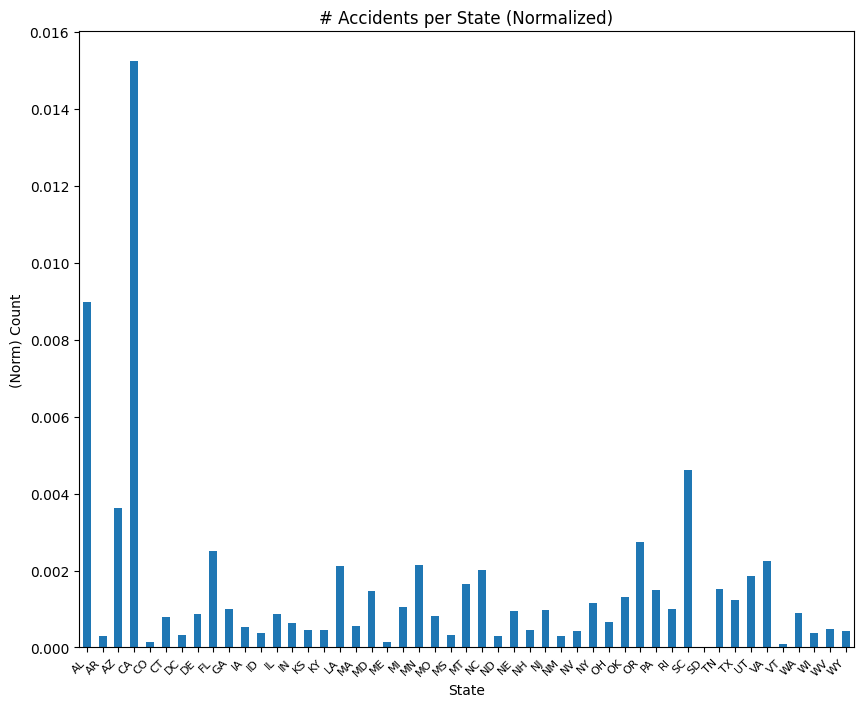

In [9]:
df_population = pd.read_csv('../data/us_population.csv')
df_regions = pd.read_csv('../data/regions.csv')

df_population = pd.merge(df_population, df_regions, left_on='US State', right_on='State')
df_population = df_population.sort_values(by=['State Code'])
df_population.index = df_population['State Code']
df_population.drop('HI', inplace=True)
state_counts_norm = state_counts / df_population['Population 2023'].values

state_counts_norm.plot(kind='bar', figsize=(10,8))
plt.title('# Accidents per State (Normalized)')
plt.xlabel('State')
plt.xticks(rotation=45, ha='right',size=8)
plt.ylabel('(Norm) Count');